In [23]:
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm
from tqdm.contrib import itertools
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [25]:
# Создание и нормализация обучающей, тестовой и выборки валидации

batch_size = 32

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_path = "C:/Users/das-s/Downloads/Plants Classification/train"
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_path = "C:/Users/das-s/Downloads/Plants Classification/test"
test_ds = datasets.ImageFolder(root=test_path, transform=transform)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [26]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

c:\Users\das-s\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


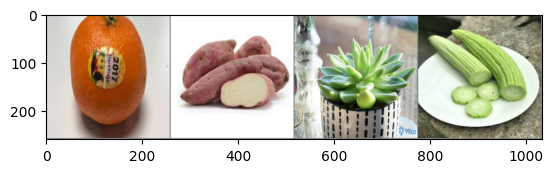

orange	 sweetpotatoes	 aloevera	 cucumber	


In [27]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
images = []
for i in range(4):
    images.append(train_features[i])
imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join(f'{train_ds.classes[train_labels[j]]}\t' for j in range(4))) # print labels


In [28]:
# Функция формирования набора данных (картинки и метки)
def extract_dataset_images(dataloader):
  labels = []
  images = []
  for batch, batch_labels in tqdm(dataloader):
    images.append(batch.detach().numpy().reshape((batch.shape[0], -1))) # Делаем картинки в виде векторов
    labels.append(batch_labels.detach().numpy())
  return np.concatenate(images), np.concatenate(labels)

In [29]:
x_train, y_train = extract_dataset_images(train_dataloader)
x_test, y_test = extract_dataset_images(test_dataloader)

100%|██████████| 57/57 [00:04<00:00, 11.53it/s]


# KNN

In [48]:
def train_and_test_KNN(x_train, y_train, x_test, y_test, n_neighbors, metric, weights):
  # Обучение KNN на картинках
  knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric = metric, weights = weights)
  knn_classifier.fit(x_train, y_train)

  # Тестирование
  # Классификация тестовых изображений с использованием KNN
  y_pred = knn_classifier.predict(x_test)

  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

In [46]:
def inverse_squared_distance(dist):
    arr = []
    for d in dist:
        arr.append(1 / (d**2))
    return arr

In [53]:
metrics_array = ["minkowski", "euclidean", "cosine"]
weights_array = ["uniform", "distance", inverse_squared_distance]
n_neighbors = [3, 5, 10, 20]

In [ ]:
#KNN accuracy
parameters = 0, "", ""
accuracy = 0

for metric, weights, n in itertools.product(metrics_array, weights_array, n_neighbors):
    if accuracy < train_and_test_KNN(x_train, y_train, x_test, y_test, n, metric, weights):
        parameters = n, metric, weights

print("Best KNN accuracy:")
print(f"n_neighbors = {parameters[0]} \nmetric = {parameters[1]} \nweights = {parameters[2]} \naccuracy = {accuracy}")

# PCA+KNN

In [45]:
def train_and_test_PCA_KNN(x_train, y_train, x_test, y_test, n_components, knn_classifier):
  pca = PCA(n_components=n_components)
  x_train_pca = pca.fit_transform(x_train)
  knn_classifier.fit(x_train_pca, y_train)

  # Тестирование
  # Применение созданного ранее PCA для тестовых данных
  x_test_pca = pca.transform(x_test)
  # Классификация тестовых изображений с использованием KNN
  y_pred = knn_classifier.predict(x_test_pca)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

In [50]:
n_components = [10, 50, 100, 200, 400]

In [ ]:
#KNN + PCA accuracy
parameters = 0, "", "", 0
accuracy = 0

for metric, weights, n_neigh, n_comp in itertools.product(metrics_array, weights_array, n_neighbors, n_components):
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neigh, metric = metric, weights = weights)
    if accuracy < train_and_test_PCA_KNN(x_train, y_train, x_test, y_test, n_comp, knn_classifier):
        parameters = n_neigh, metric, weights, n_comp

print("Best KNN accuracy:")
print(f"n_neighbors = {parameters[0]} \nmetric = {parameters[1]} \nweights = {parameters[2]} \nn_components = {parameters[3]} \naccuracy = {accuracy}")

# CNN+PCA+KNN

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
from torchvision.models import vgg16
model = vgg16(pretrained=True)
model.classifier = nn.Flatten(start_dim= 1)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
def extract_features(dataset, model):
    features = []
    labels = []
    for batch_images, batch_labels in tqdm(dataset):
        batch_features = model(batch_images.to(device))
        labels.append(batch_labels.detach().numpy())
        features.append(batch_features.cpu().detach().numpy())
    return np.concatenate(features), np.concatenate(labels)

In [40]:
x_train_features, y_train_labels = extract_features(train_dataloader, model)
x_test_features, y_test_labels = extract_features(test_dataloader, model)

100%|██████████| 57/57 [00:08<00:00,  6.85it/s]


In [54]:
#KNN + PCA + CNN accuracy
parameters = 0, "", "", 0
accuracy = 0

for metric, weights, n_neigh, n_comp in itertools.product(metrics_array, weights_array, n_neighbors, n_components):
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neigh, metric = metric, weights = weights)
    if accuracy < train_and_test_PCA_KNN(x_train_features, y_train_labels, x_test_features, y_test_labels, n_comp, knn_classifier):
        parameters = n_neigh, metric, weights, n_comp

print("Best KNN accuracy:")
print(f"n_neighbors = {parameters[0]} \nmetric = {parameters[1]} \nweights = {parameters[2]} \nn_components = {parameters[3]} \naccuracy = {accuracy}")

  8%|▊         | 14/180 [00:36<07:12,  2.61s/it]


KeyboardInterrupt: 

In [23]:
knn_classifier = KNeighborsClassifier(n_neighbors=parameters[0], metric=parameters[1], weights=parameters[2])
pca = PCA(n_components=parameters[3])

x_train_pca = pca.fit_transform(x_train_features)
knn_classifier.fit(x_train_pca, y_train_labels)

x_test_pca = pca.transform(x_test_features)
y_pred = knn_classifier.predict(x_test_pca)

print(classification_report(y_test_labels, y_pred, target_names=test_ds.classes))

                precision    recall  f1-score   support

        Burger       0.82      0.79      0.80       200
Crispy Chicken       0.82      0.94      0.87       100
         Donut       0.87      0.90      0.88       200
         Fries       0.70      0.89      0.78       100
       Hot Dog       0.83      0.72      0.77       200
         Pizza       0.84      0.91      0.87       200
      Sandwich       0.94      0.73      0.83       200
          Taco       0.49      0.76      0.59       100
       Taquito       0.36      0.20      0.26       100

      accuracy                           0.78      1400
     macro avg       0.74      0.76      0.74      1400
  weighted avg       0.78      0.78      0.77      1400



C:\Users\das-s\AppData\Local\Temp\ipykernel_30636\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))
